<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/kang/CTC_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'



with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [0]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [0]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [0]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    # If you have already saved mel-spectrogram, skip mel creating process
    if not os.path.isfile(mel_path):
        
        y, sr = librosa.core.load(wav_path) # I made a mistake... sr=fs
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
#       Sxx = np.maximum(Sxx, eps)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

        np.save(mel_path, norm_log_mel_specgram)

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    # Load the spectrogram image from the disk
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
    
    # Check if tensor number i is already loaded, if not load and returns the image
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    # Try loading every images
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    # Get batch
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            # Time shift, add zeros in front of an image
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
            
            # Add random noise
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            # Value less than 0 or more than 1 is clamped to 0 and 1
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [0]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

12833
12833
10266
10266
2567


In [0]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 128)
preloader_eval.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'commented_test_2'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-09 13:40:40
Mean Train Loss: 0.1083294634043475
Mean Evaluation Loss: 0.07676613370129137
-------------------------------------------------------------------------------------------------------
09-09 13:41:14
Mean Train Loss: 0.0757977746687597
Mean Evaluation Loss: 0.07548001297209779
-------------------------------------------------------------------------------------------------------
09-09 13:41:49
Mean Train Loss: 0.07453913917755535
Mean Evaluation Loss: 0.07466690030339794
-------------------------------------------------------------------------------------------------------
09-09 13:42:23
Mean Train Loss: 0.07395701969522708
Mean Evaluation Loss: 0.07408510895891568
-------------------------------------------------------------------------------------------------------
09-09 13:42:58
Mean Train Loss: 0.07316220690153749
Mean Evaluation Loss: 0.07326831523718905
------------------------------------------------------------------------------------------------------

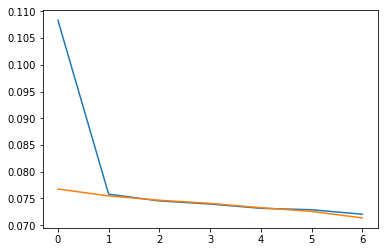

아---------------------------------------------------------------------------------------------------------------  -  --ᄋ---ᆻᆻᄃ다-------------------------------------------------------.<eos><eos>
아  ᄋᆻ다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


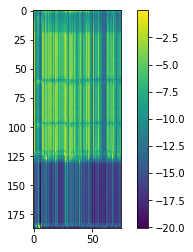

아------------------------------------------------------------------------- --------  --------------ᆸᆻᄋᄋᄋ-ᅭ------------------------------------------------.<eos><eos>
아  ᆸᆻ요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


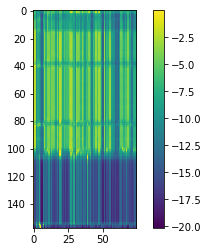

-------------------------------------------------------------------------------------------------------
09-09 13:44:43
Mean Train Loss: 0.07110323346797076
Mean Evaluation Loss: 0.07095825109254254
-------------------------------------------------------------------------------------------------------
09-09 13:45:18
Mean Train Loss: 0.06955202161045185
Mean Evaluation Loss: 0.06865348741597395
-------------------------------------------------------------------------------------------------------
09-09 13:45:53
Mean Train Loss: 0.06312388215281625
Mean Evaluation Loss: 0.06064709080935908
-------------------------------------------------------------------------------------------------------
09-09 13:46:27
Mean Train Loss: 0.05754549869402615
Mean Evaluation Loss: 0.05626438767806706
-------------------------------------------------------------------------------------------------------
09-09 13:47:02
Mean Train Loss: 0.060047977586665656
Mean Evaluation Loss: 0.06524041817879336
---------

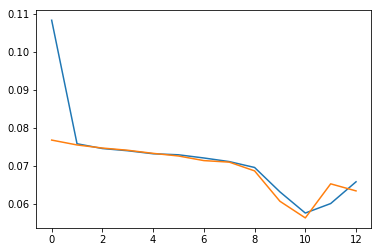

아---------------------ᅡ--ᅳ--아- 아-아-아----아----아-아--- -ᅳ-------- 아--ᄋ--아--아---ᅡ-아-아- 아-이----- 아-아--아- 아-아- 아-------았아----------------------------------------------.<eos>
아ᅡᅳ아 아아아아아아 ᅳ 아ᄋ아아ᅡ아아 아이 아아아 아아 아았아.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


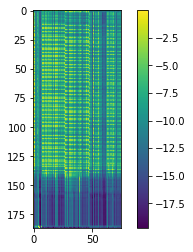

아----------------------아-이---- 아-이------아- 아- 아-이- 아- 아-어------  아-이- 아-아-이-----아-이- 이-ᄋ아 이--이-다------------------------------------.<eos>
아아이 아이아 아 아이 아 아어 아이 아아이아이 이아 이이다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


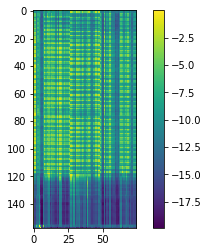

-------------------------------------------------------------------------------------------------------
09-09 13:48:13
Mean Train Loss: 0.06505922374571545
Mean Evaluation Loss: 0.07456042215341119
-------------------------------------------------------------------------------------------------------
09-09 13:48:48
Mean Train Loss: 0.07329812598957305
Mean Evaluation Loss: 0.07426993335608666
-------------------------------------------------------------------------------------------------------
09-09 13:49:23
Mean Train Loss: 0.07238671102521728
Mean Evaluation Loss: 0.07165590553550578
-------------------------------------------------------------------------------------------------------
09-09 13:49:57
Mean Train Loss: 0.06785296557326084
Mean Evaluation Loss: 0.06449004010305492
-------------------------------------------------------------------------------------------------------
09-09 13:50:32
Mean Train Loss: 0.06172703656114983
Mean Evaluation Loss: 0.059331920579224956
---------

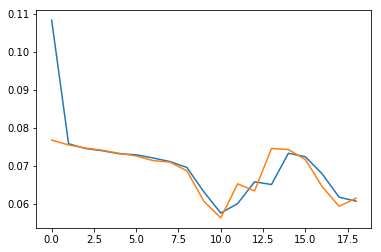

가---------------이-아-아-아--사-아-----사-이-아- 아-아-아-아-으-----------아-아- 사-사-사- 아-아-으- 가-이-으- 이-니--다-----------------------------------------------.<eos>
가이아아아사아사이아 아아아아으아아 사사사 아아으 가이으 이니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


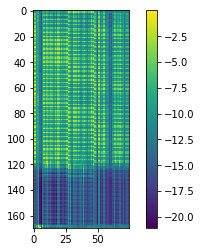

가----------------아-으- 이-아-이-으--------사-아-으- 이-이-으-으- 아-이-아-으- 아-아-으- 이-이-어-ᄋᄋᄋ-ᅭ----------------------------------------------------.<eos>
가아으 이아이으사아으 이이으으 아이아으 아아으 이이어요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


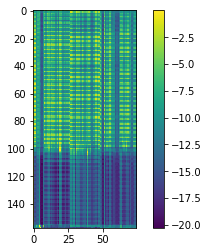

-------------------------------------------------------------------------------------------------------
09-09 13:51:42
Mean Train Loss: 0.0626884409534728
Mean Evaluation Loss: 0.06059710446750316
-------------------------------------------------------------------------------------------------------
09-09 13:52:17
Mean Train Loss: 0.06128659128529338
Mean Evaluation Loss: 0.06153560387448258
-------------------------------------------------------------------------------------------------------
09-09 13:52:52
Mean Train Loss: 0.06276159275246038
Mean Evaluation Loss: 0.07036636144626476
-------------------------------------------------------------------------------------------------------
09-09 13:53:26
Mean Train Loss: 0.0681586258579459
Mean Evaluation Loss: 0.06503262588970196
-------------------------------------------------------------------------------------------------------
09-09 13:54:01
Mean Train Loss: 0.061546709002652196
Mean Evaluation Loss: 0.06109731466369012
-----------

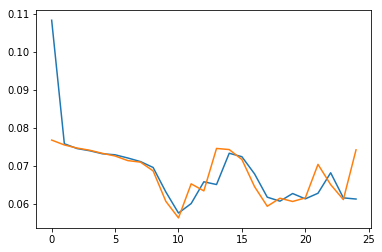

아-----------------으--어-----으--아--아-아--자--지--ᅳ--오---------으--사--아--어--어--어-아--아--아--아--으--이-다-다ᅡᅡ------------------------------------------------.<eos>
아으어으아아아자지ᅳ오으사아어어어아아아아으이다다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


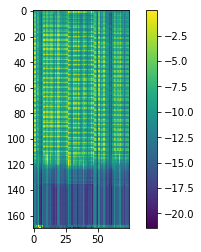

그---------------------으--어- 으- 으--이-아--시--시--시--스--서--어-----사--시--시--아- 아- 이--아-딨다--ᅡ-ᅡ----------------------------------------------.<eos>
그으어 으 으이아시시시스서어사시시아 아 이아딨다ᅡᅡ.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


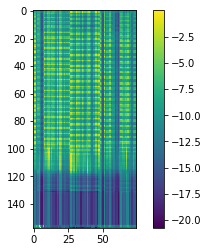

-------------------------------------------------------------------------------------------------------
09-09 13:55:11
Mean Train Loss: 0.0632423781029995
Mean Evaluation Loss: 0.06653182664207528
-------------------------------------------------------------------------------------------------------
09-09 13:55:47
Mean Train Loss: 0.06228887755544837
Mean Evaluation Loss: 0.05887231784833774
-------------------------------------------------------------------------------------------------------
09-09 13:56:21
Mean Train Loss: 0.061417291338818056
Mean Evaluation Loss: 0.06894422851861075
-------------------------------------------------------------------------------------------------------
09-09 13:56:56
Mean Train Loss: 0.06934841160469266
Mean Evaluation Loss: 0.0638585730229204
-------------------------------------------------------------------------------------------------------
09-09 13:57:30
Mean Train Loss: 0.06283607095018309
Mean Evaluation Loss: 0.06015292179092832
-----------

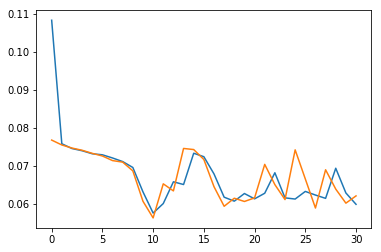

으--------------ᅳᅵ-이-----사--ᅳ--ᅳ- 이--ᅳ 으-으------ᅵ- 사-이--으- 아-으-으-------- 아 아-을 이-이 이 이-서-아 있이-ᅵᄃ다----------------------------------------------.<eos>
으ᅳᅵ이사ᅳᅳ 이ᅳ 으으ᅵ 사이으 아으으 아 아을 이이 이 이서아 있이ᅵ다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


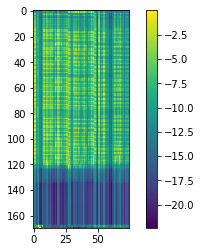

아----------------ᅡ- 아 오 오 으-이-ᄋ------- 사 시- 이 이 이 오 오 아ᅡ 아 아 이 오 아 아-아ᅡ아ᄋ어ᄋᄋ요ᅭ------------------------------------------------------.<eos>
아ᅡ 아 오 오 으이ᄋ 사 시 이 이 이 오 오 아 아 아 이 오 아 아아아어요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


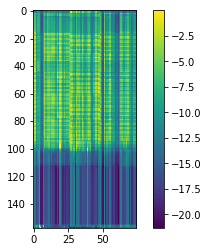

-------------------------------------------------------------------------------------------------------
09-09 13:58:42
Mean Train Loss: 0.06145158160678276
Mean Evaluation Loss: 0.0637451507011016
-------------------------------------------------------------------------------------------------------
09-09 13:59:16
Mean Train Loss: 0.06486150408934035
Mean Evaluation Loss: 0.06385402364834791
-------------------------------------------------------------------------------------------------------
09-09 13:59:51
Mean Train Loss: 0.06150715471621904
Mean Evaluation Loss: 0.06008622983529098
-------------------------------------------------------------------------------------------------------
09-09 14:00:25
Mean Train Loss: 0.05771109431156405
Mean Evaluation Loss: 0.05744482469849768
-------------------------------------------------------------------------------------------------------
09-09 14:01:00
Mean Train Loss: 0.056250233970860784
Mean Evaluation Loss: 0.056736099271835996
---------

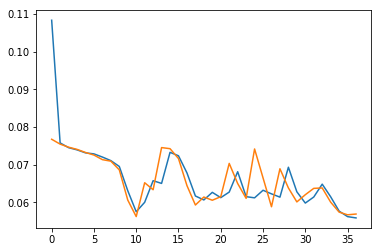

그--------------------------ᅳ-은 사ᅡ아--ᅡ---- 자ᅡ-ᅵᅵ 져---------------- 고-고 가ᅡ-ᄉᄉ-ᄉᄉ- ᅡᅡ-오 ᅥ-시ᅵ------- -ᅵᅵ이ᅩ오ᅩ ᅵᅩ-일오 이  ᅡᅡ ᅡᅡ-ᄃ다ᅡ-------------------------------------------.<eos>
그ᅳ은 사아ᅡ 자ᅵ 져 고고 가ᄉᄉ ᅡ오 ᅥ시 ᅵ이ᅩ오 ᅵᅩ일오 이 ᅡ ᅡ다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


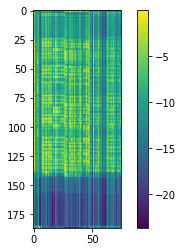

우---------------------이 선 ᅡᅡ-으--- 이-은 조-지ᅵ이시ᄉ사-이-서ᅥ------- 지ᄋᄋᆫ 지이ᅵ을 ᅡᆫ 고 시ᅵ올이 사ᅡ-깁니ᅵ다ᅡ---------------------------------------.<eos>
우이 선 ᅡ으 이은 조지이시사이서 지ᄋᆫ 지이을 ᅡᆫ 고 시올이 사깁니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


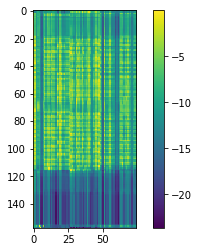

-------------------------------------------------------------------------------------------------------
09-09 14:02:11
Mean Train Loss: 0.054245748893433914
Mean Evaluation Loss: 0.05484795114083243
-------------------------------------------------------------------------------------------------------
09-09 14:02:45
Mean Train Loss: 0.0531559857355782
Mean Evaluation Loss: 0.0548768626826704
-------------------------------------------------------------------------------------------------------
09-09 14:03:20
Mean Train Loss: 0.05242502672806852
Mean Evaluation Loss: 0.052818465298601944
-------------------------------------------------------------------------------------------------------
09-09 14:03:55
Mean Train Loss: 0.050937728588271294
Mean Evaluation Loss: 0.051653852670373326
-------------------------------------------------------------------------------------------------------
09-09 14:04:30
Mean Train Loss: 0.05002919595235547
Mean Evaluation Loss: 0.05016661158382852
--------

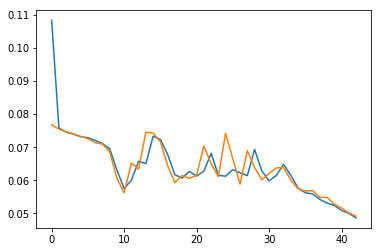

하--------------------------시-ᄋᆫ 사 슬  언은-가아----ᅩ----- 자-지-으 가ᅡ-신 자-는----  ᅡ-하 사ᅡ한 거- 고이 하 시 시-십니다--------------------------------------.<eos>
하시ᄋᆫ 사 슬 언은가아ᅩ 자지으 가신 자는 ᅡ하 사한 거 고이 하 시 시십니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


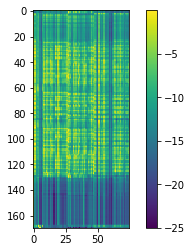

우--------------이-에 하-이-으------  ᅳ-ᄋ고이ᅵ이 아-시- 으-이-아-  ᅡᅡ-고ᄋ어 한 자 하 안안 ᅵ  ᄋ ᆻᆻ십니-다------------------------------------------------.<eos>
우이에 하이으 ᅳᄋ고이이 아시 으이아 ᅡ고어 한 자 하 안안 ᅵ ᄋ ᆻ십니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


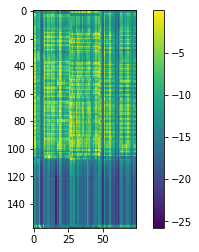

-------------------------------------------------------------------------------------------------------
09-09 14:05:40
Mean Train Loss: 0.04769120634285763
Mean Evaluation Loss: 0.04807846921993546
-------------------------------------------------------------------------------------------------------
09-09 14:06:15
Mean Train Loss: 0.04656451899108899
Mean Evaluation Loss: 0.0467634032925088
-------------------------------------------------------------------------------------------------------
09-09 14:06:49
Mean Train Loss: 0.04547340315329787
Mean Evaluation Loss: 0.045733716595253104
-------------------------------------------------------------------------------------------------------
09-09 14:07:24
Mean Train Loss: 0.04421660380848482
Mean Evaluation Loss: 0.04571238445734144
-------------------------------------------------------------------------------------------------------
09-09 14:07:59
Mean Train Loss: 0.04391392241145613
Mean Evaluation Loss: 0.04365850885369415
----------

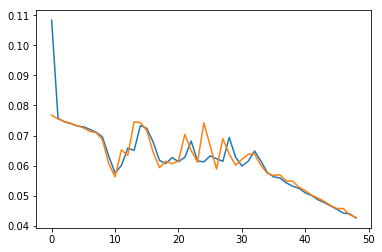

나------------------------는으--ᄉ사-다------  자-이- ᅡᅡ-숙-그-------  -록구-한 시ᄉ수하ᅡ-ᅳᆫ 거-시------  기 공공저ᅩ이알어ᅥ으ᅵ ᅡᅡ 한ᄃ다---------------------------.<eos>
나는으사다 자이 ᅡ숙그 록구한 시수하ᅳᆫ 거시 기 공공저ᅩ이알어으ᅵ ᅡ 한다.<eos>
나는 의사가 자기 가족 중 누군가를 수술하는 것이 비도덕적이라고 생각한다.<eos>-------------------


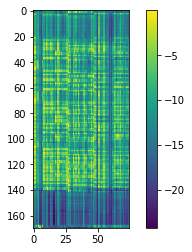

그-------------------ᅡᆫ하ᅡ ᅡᅡ ᄋ  시 든이 상-안 이 이-에-다ᅡ-이-게-에---------  아-럿성ᅳᅳᆫ 며 알인갠이ᅵ이  해-여ᄋᄋ요ᅭ--------------------------------.<eos>
그ᅡᆫ하 ᅡ ᄋ 시 든이 상안 이 이에다이게에 아럿성ᅳᆫ 며 알인갠이이 해여요.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


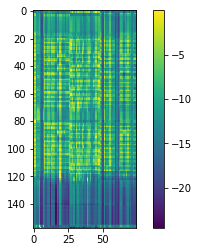

-------------------------------------------------------------------------------------------------------
09-09 14:09:09
Mean Train Loss: 0.04193512363292109
Mean Evaluation Loss: 0.041585880038542494
-------------------------------------------------------------------------------------------------------
09-09 14:09:44
Mean Train Loss: 0.040819754980001684
Mean Evaluation Loss: 0.04095248160548349
-------------------------------------------------------------------------------------------------------
09-09 14:10:18
Mean Train Loss: 0.03995612151098863
Mean Evaluation Loss: 0.04028267458382977
-------------------------------------------------------------------------------------------------------
09-09 14:10:53
Mean Train Loss: 0.0390919592822046
Mean Evaluation Loss: 0.03938606489122353
-------------------------------------------------------------------------------------------------------
09-09 14:11:28
Mean Train Loss: 0.03829762428597757
Mean Evaluation Loss: 0.03845974940821114
---------

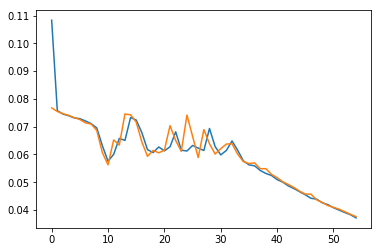

그-----------------자-은 저ᄉ시-ᅳᅦ 준는늘 이-여-에-----  여-이- ᄋ ᄀ구ᄅ로  송가ᅡ늘 대-는-  가ᅡ-모  ᄋᆯᄉ신ᅳᅳ  없었ᆻ-다--------------------------------------------.<eos>
그자은 저시ᅳᅦ 준는늘 이여에 여이 ᄋ 구로 송가늘 대는 가모 ᄋᆯ신ᅳ 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


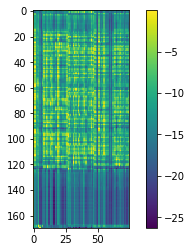

애------------------ 수-시를 ᅳᆯ 대 대 글에-   드ᅢ항글ᄅ오 덜르-을 고-어-ᄋᆯ려--고-  성 걸 하-스-앴어ᄋ요----------------------------------------------.<eos>
애 수시를 ᅳᆯ 대 대 글에 드ᅢ항글ᄅ오 덜르을 고어ᄋᆯ려고 성 걸 하스앴어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


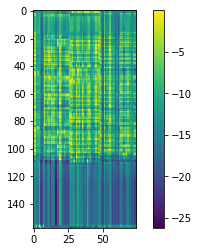

-------------------------------------------------------------------------------------------------------
09-09 14:12:39
Mean Train Loss: 0.03653234323858016
Mean Evaluation Loss: 0.03788538355554367
-------------------------------------------------------------------------------------------------------
09-09 14:13:13
Mean Train Loss: 0.03632110407020044
Mean Evaluation Loss: 0.03693042396948266
-------------------------------------------------------------------------------------------------------
09-09 14:13:48
Mean Train Loss: 0.035257561641792536
Mean Evaluation Loss: 0.03682789808636781
-------------------------------------------------------------------------------------------------------
09-09 14:14:23
Mean Train Loss: 0.03473774258415356
Mean Evaluation Loss: 0.035672124368518875
-------------------------------------------------------------------------------------------------------
09-09 14:14:57
Mean Train Loss: 0.0340136348275483
Mean Evaluation Loss: 0.035152260368528004
--------

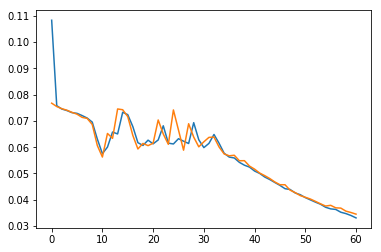

사----------------암블르  멀이ᅵᅵ는 서-람을 돌릴-대----- ᄉ서ᅩ으  ᅩ 목과-에  만들 어 이 ᄀ다애 기-읍니ᄃ다-----------------------------------------------------------------------.<eos>
사암블르 멀이는 서람을 돌릴대 서ᅩ으 ᅩ 목과에 만들 어 이 ᄀ다애 기읍니다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


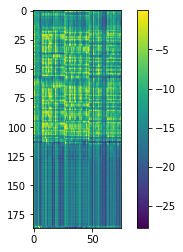

우---------------------리 바ᅡ-ᄀ에 에-는 대-둑군에  사-공 드-이----  이령아 서ᄉ시에 대ᄒ어ᄒ헌드 읍니ᄃ다------------------------------------------------.<eos>
우리 바ᄀ에 에는 대둑군에 사공 드이 이령아 서시에 대ᄒ어헌드 읍니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


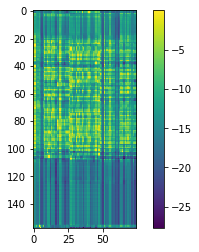

-------------------------------------------------------------------------------------------------------
09-09 14:16:08
Mean Train Loss: 0.032751091577646205
Mean Evaluation Loss: 0.03438749968051787
-------------------------------------------------------------------------------------------------------
09-09 14:16:42
Mean Train Loss: 0.031909624402407806
Mean Evaluation Loss: 0.03330831856286963
-------------------------------------------------------------------------------------------------------
09-09 14:17:17
Mean Train Loss: 0.031216452199473697
Mean Evaluation Loss: 0.03348444583247071
-------------------------------------------------------------------------------------------------------
09-09 14:17:51
Mean Train Loss: 0.030811638398281035
Mean Evaluation Loss: 0.03190915601249533
-------------------------------------------------------------------------------------------------------
09-09 14:18:26
Mean Train Loss: 0.029819442148082364
Mean Evaluation Loss: 0.03160875561790868
-----

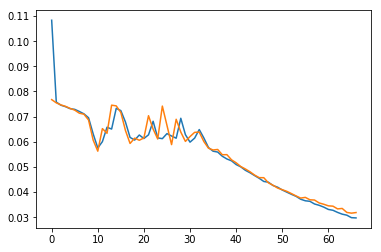

다---------------ᆷ무-이  면녕-간 형은 산-곤 나-은로ᅩ-------  그ᅳᅳᆫ 사 시-함이 설일 ᄃ다-고-  마 안 못어ᅥᆹ-다------------------------------------------------.<eos>
담무이 면녕간 형은 산곤 나은로 근 사 시함이 설일 다고 마 안 못없다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


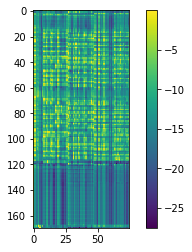

주-----------------송-하-지-마ᅡ-ᆫᆫ--- ᄉ서-센이-의 ᄀ개르-ᄋ은--  시-곰 가ᅡ연ᄉ서ᄋ  곤느 거ᅥ 았ᄉ습니ᄃ다-------------------------------------------------.<eos>
주송하지만 서센이의 개르은 시곰 가연서ᄋ 곤느 거 았습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


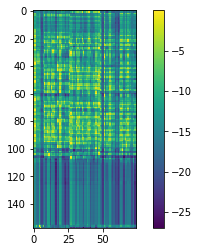

-------------------------------------------------------------------------------------------------------
09-09 14:19:38
Mean Train Loss: 0.029037994249760047
Mean Evaluation Loss: 0.031215698009103583
-------------------------------------------------------------------------------------------------------
09-09 14:20:12
Mean Train Loss: 0.028601652115938007
Mean Evaluation Loss: 0.030871333734569194
-------------------------------------------------------------------------------------------------------
09-09 14:20:47
Mean Train Loss: 0.028134789457943708
Mean Evaluation Loss: 0.030520253750026233
-------------------------------------------------------------------------------------------------------
09-09 14:21:22
Mean Train Loss: 0.02779114871615782
Mean Evaluation Loss: 0.029955280693703457
-------------------------------------------------------------------------------------------------------
09-09 14:21:56
Mean Train Loss: 0.027213526195387302
Mean Evaluation Loss: 0.029760020660014312
-

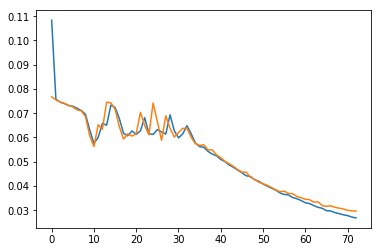

지---------------궁이-에 해ᄋᄋᆯᆯ퍼ᅥ들에 설이-하-고ᅩᄌᄌ자--다-며ᅧᆫ------ 노ᅩ-다-해ᄒ햐ᅣ의 사ᅡ앙이ᅵ   역-하-기 있습니ᄃ다---------------------------------------------------------------.<eos>
지궁이에 해ᄋᆯ퍼들에 설이하고자다면 노다해햐의 사앙이 역하기 있습니다.<eos>
중국에 해외 법인을 설립하고자 한다면 고려해야 할 사항이 몇 가지 있습니다.<eos>-----------------


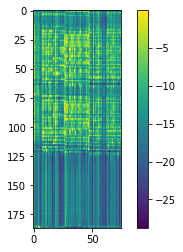

그-------------------사-라ᅡ알고ᅩ ᅵᅵᇁ꼰이 사-아ᅡᆫ 이-기-한 다는 게-----------  나-럿수ᄋ는  며하ᅡᆫ긴근ᆫ이기  안여ᄋ야ᅭᅭ-------------------------------.<eos>
그사라알고 ᅵᇁ꼰이 사안 이기한 다는 게 나럿수ᄋ는 며한긴근이기 안여야ᅭ.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


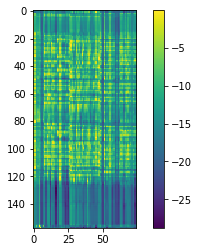

-------------------------------------------------------------------------------------------------------
09-09 14:23:08
Mean Train Loss: 0.026729153770270884
Mean Evaluation Loss: 0.02875246374407745
-------------------------------------------------------------------------------------------------------
09-09 14:23:42
Mean Train Loss: 0.025698265836913176
Mean Evaluation Loss: 0.028440062043815287
-------------------------------------------------------------------------------------------------------
09-09 14:24:17
Mean Train Loss: 0.025520973179287237
Mean Evaluation Loss: 0.02819992150952238
-------------------------------------------------------------------------------------------------------
09-09 14:24:52
Mean Train Loss: 0.025031881078743205
Mean Evaluation Loss: 0.02798500002130085
-------------------------------------------------------------------------------------------------------
09-09 14:25:27
Mean Train Loss: 0.024658913063144976
Mean Evaluation Loss: 0.02754808756488308
----

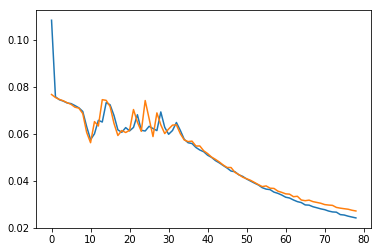

이-------------  시-의  실ᄋᄋᄋ  자리-소-자ᅡᄂ는  ᄋ이래- 잘이-수-자의  새-래-이-ᄃ다------------ -각ᄎ수-자ᅡᄋ의 야-곤 ᄐ타-이-다--------  이-ᅵᅵ-수-르ᅳ-------------------.<eos>
이 시의 실ᄋ 자리소자는 이래 잘이수자의 새래이다 각ᄎ수자의 야곤 타이다 이ᅵ수르.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


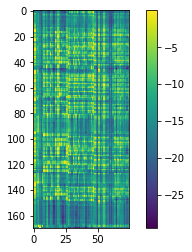

저------------------나  길곡시ᅵ 이-잔ᄋᄋᄋ우시은 선닌 게-는ᆫ---  소-주자ᅡᆫ ᅧᅧᆼ을 ᄉ서ᅥ이ᄉ스ᄅᄅᆯᆯ 재-공-합니ᄃ다----------------------------------------.<eos>
저나 길곡시 이잔우시은 선닌 게는 소주잔 ᅧᆼ을 서이스ᄅᆯ 재공합니다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


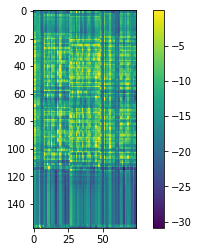

-------------------------------------------------------------------------------------------------------
09-09 14:26:38
Mean Train Loss: 0.0240594590198332
Mean Evaluation Loss: 0.02678292121289603
-------------------------------------------------------------------------------------------------------
09-09 14:27:13
Mean Train Loss: 0.023574888807766082
Mean Evaluation Loss: 0.02665828745459526
-------------------------------------------------------------------------------------------------------
09-09 14:27:47
Mean Train Loss: 0.023072312860314387
Mean Evaluation Loss: 0.027581784954800268
-------------------------------------------------------------------------------------------------------
09-09 14:28:22
Mean Train Loss: 0.023246096572020057
Mean Evaluation Loss: 0.026260355725155865
-------------------------------------------------------------------------------------------------------
09-09 14:28:57
Mean Train Loss: 0.022408032818790367
Mean Evaluation Loss: 0.025937065205230675
----

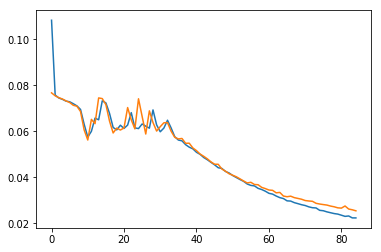

제---------------가 ᄀ고 오-프ᄅᄋᄋ  기ᄋ열일따ᄅ있다는 이ᄀ기을 드-았을-대---------  저-는 종-마----  밀이-지기 아-갔ᆻ어ᄋᄋᄋ요-------------------------------------.<eos>
제가 고 오프ᄅᄋ 기열일따ᄅ있다는 이기을 드았을대 저는 종마 밀이지기 아갔어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


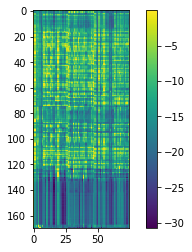

우-----------리  대-악게-는ᆫ--- ᄋ이-국이 이-억ᄉ새-을ᄋ이-ᆫᆫ 한ᄀ고건 강장가  말령기-가 있습니ᄃ다-------------------------------------------------.<eos>
우리 대악게는 이국이 이억새을인 한고건 강장가 말령기가 있습니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


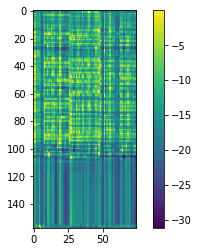

-------------------------------------------------------------------------------------------------------
09-09 14:30:08
Mean Train Loss: 0.022244542036518298
Mean Evaluation Loss: 0.02554015428519462
-------------------------------------------------------------------------------------------------------
09-09 14:30:42
Mean Train Loss: 0.0219536807968947
Mean Evaluation Loss: 0.025429927941895945
-------------------------------------------------------------------------------------------------------
09-09 14:31:18
Mean Train Loss: 0.021414690928005506
Mean Evaluation Loss: 0.02506757560600288
-------------------------------------------------------------------------------------------------------
09-09 14:31:52
Mean Train Loss: 0.02104670099417055
Mean Evaluation Loss: 0.024459335185948845
-------------------------------------------------------------------------------------------------------
09-09 14:32:27
Mean Train Loss: 0.02095168610213666
Mean Evaluation Loss: 0.024778451824290164
------

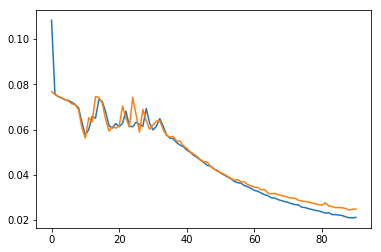

호-----------ᆫ낼가ᅡ가 ᄀ거짐말르ᅳᆯ 냈는 ᅦᅦ---------  나-지에  거직 마ᄅᆯ라ᅡ 골때-문엘-  어-무 학데 더ᄋ우흐-혔ᄋ어요ᅭ-------------------------------------------------------------.<eos>
혼낼가가 거짐말를 냈는 ᅦ 나지에 거직 마ᄅᆯ라 골때문엘 어무 학데 더우흐혔어요.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


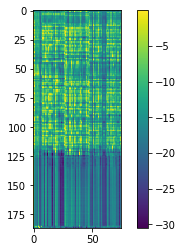

여------------------ᆼ가  오른 할ᄂ녕의  애ᄀ구-는 간간-게- 들에-  서-울을 방문하고ᅩ 있-다---------------------------------------------------------.<eos>
영가 오른 할녕의 애구는 간간게 들에 서울을 방문하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


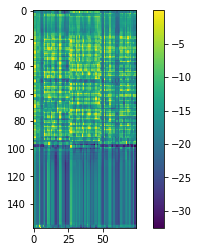

-------------------------------------------------------------------------------------------------------
09-09 14:33:37
Mean Train Loss: 0.020719842035522178
Mean Evaluation Loss: 0.025372660708946133
-------------------------------------------------------------------------------------------------------
09-09 14:34:12
Mean Train Loss: 0.02011813133229469
Mean Evaluation Loss: 0.024041572046652138
-------------------------------------------------------------------------------------------------------
09-09 14:34:47
Mean Train Loss: 0.019423635084466657
Mean Evaluation Loss: 0.023687654759020304
-------------------------------------------------------------------------------------------------------
09-09 14:35:21
Mean Train Loss: 0.019520596873290687
Mean Evaluation Loss: 0.024645439796935776
-------------------------------------------------------------------------------------------------------
09-09 14:35:56
Mean Train Loss: 0.019075283678243325
Mean Evaluation Loss: 0.024069866231697743
-

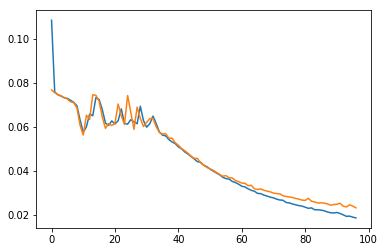

여--------------러-분는 이-곳-에-서------   자ᅡᆼ--ᅵᅵᅵ-----,   뵈--까----,  ᄐ퓰-에--든---- ᄃ다-항한 송이ᅵᅵ 본들을 뵤-술 수 있습니ᄃ다----------------------------------------.<eos>
여러분는 이곳에서 장ᅵ, 뵈까, ᄐ퓰에든 다항한 송이 본들을 뵤술 수 있습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


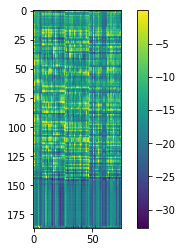

그------------------- 사-람은 술-잘이-에-서ᅥ----  자ᅡᆯ기 앴나ᅡ 이-햐-기ᄅ로---  사ᄅ람들을 지보ᄒ학기  안 든ᆫ다ᅡ------------------------------------.<eos>
그 사람은 술잘이에서 잘기 앴나 이햐기로 사람들을 지보학기 안 든다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


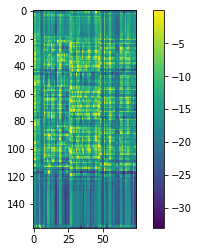

-------------------------------------------------------------------------------------------------------
09-09 14:37:06
Mean Train Loss: 0.018775925544432297
Mean Evaluation Loss: 0.023191006782050952
-------------------------------------------------------------------------------------------------------
09-09 14:37:41
Mean Train Loss: 0.01826449612658252
Mean Evaluation Loss: 0.02296753812692146
-------------------------------------------------------------------------------------------------------
09-09 14:38:15
Mean Train Loss: 0.017988782258860542
Mean Evaluation Loss: 0.02280743777440354
-------------------------------------------------------------------------------------------------------
09-09 14:38:50
Mean Train Loss: 0.017865403449418837
Mean Evaluation Loss: 0.02274671861419921
-------------------------------------------------------------------------------------------------------
09-09 14:39:25
Mean Train Loss: 0.017596916533254025
Mean Evaluation Loss: 0.022936083568874967
----

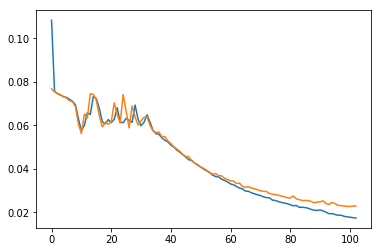

차--------------------함ᄆ이고ᅩ슷 이사-핬을 때---------  거-ᄋ허선 닪는 거ᄅ이ᄋᄋ 신역홈 가-기ᄀ가 있따는ᆫ데ᅦ---   첨ᆷ ᄌ좋ᇂ았ᄋ어ᄋᄋ요ᅭ------------------------------------------.<eos>
차함ᄆ이고슷 이사핬을 때 거ᄋ허선 닪는 거ᄅ이ᄋ 신역홈 가기가 있따는데 첨 좋았어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


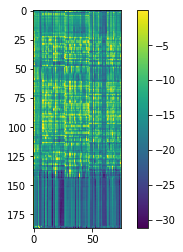

우-------------------리ᅵ 가ᄅ기에 이-는 대-묵군헤ᅦ 상공-들이---  이-럭으 소수ᄋ에 해홍어ᅩ 드-입니ᅵ다-------------------------------------------------.<eos>
우리 가ᄅ기에 이는 대묵군헤 상공들이 이럭으 소수에 해홍어ᅩ 드입니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


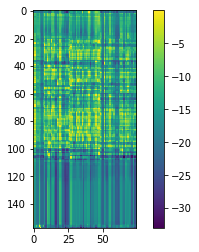

-------------------------------------------------------------------------------------------------------
09-09 14:40:35
Mean Train Loss: 0.017187510065511
Mean Evaluation Loss: 0.022527225473318636
-------------------------------------------------------------------------------------------------------
09-09 14:41:10
Mean Train Loss: 0.016526773783905248
Mean Evaluation Loss: 0.02234110336715362
-------------------------------------------------------------------------------------------------------
09-09 14:41:44
Mean Train Loss: 0.01643414671578935
Mean Evaluation Loss: 0.022826024630954362
-------------------------------------------------------------------------------------------------------
09-09 14:42:19
Mean Train Loss: 0.016205899841787493
Mean Evaluation Loss: 0.021834159758509726
-------------------------------------------------------------------------------------------------------
09-09 14:42:54
Mean Train Loss: 0.015983635613475187
Mean Evaluation Loss: 0.02207765045097096
------

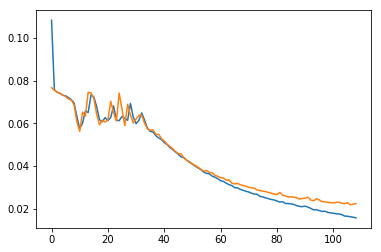

제---------------가-도 ᄋ오패파ᅡ이 지여ᅧᆫᄋᆯ 따ᅡ맀따는 이ᄃ기를 들었을 때---------  저-는 종-마--ᆯ-  밀개 지기 않아ᅡᆻ어ᄋᄋ요ᅭ-------------------------------------.<eos>
제가도 오패파이 지연ᄋᆯ 따맀따는 이ᄃ기를 들었을 때 저는 종말 밀개 지기 않았어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


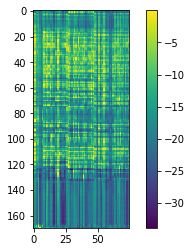

여-------------------ᆼ한 오ᄃ단 한령의 외-묵은ᆫ 건간ᆼᄀ게-들이-  서-운을 방문하ᄀ고 있ᆻ다--------------------------------------------------------.<eos>
영한 오단 한령의 외묵은 건간ᆼ게들이 서운을 방문하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


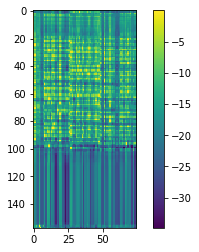

-------------------------------------------------------------------------------------------------------
09-09 14:44:04
Mean Train Loss: 0.015496913612315217
Mean Evaluation Loss: 0.022308715273678215
-------------------------------------------------------------------------------------------------------
09-09 14:44:39
Mean Train Loss: 0.015426109765174681
Mean Evaluation Loss: 0.023004062755971066
-------------------------------------------------------------------------------------------------------
09-09 14:45:13
Mean Train Loss: 0.015596746917042456
Mean Evaluation Loss: 0.022703357744619297
-------------------------------------------------------------------------------------------------------
09-09 14:45:48
Mean Train Loss: 0.015248647512020218
Mean Evaluation Loss: 0.021982961637652183
-------------------------------------------------------------------------------------------------------
09-09 14:46:23
Mean Train Loss: 0.014727158218497268
Mean Evaluation Loss: 0.02156567603982322
-

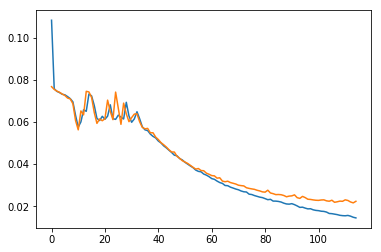

최-------------------금의  설문 주-서--혈ᆯᆯᄀ가-----  눈답저의  과--반-수-가------  새- 규-정의  ᅡᅡ내ᅢ하ᄂ니 것으로ᅩ 닺-타-났ᆻ다ᅡ-----------------------------------------------.<eos>
최금의 설문 주서혈가 눈답저의 과반수가 새 규정의 ᅡ내하니 것으로 닺타났다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


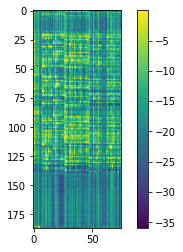

여----------------ᆼ간 오단ᆼ한-녕의 의 묵인ᆫ 건-강에--들에-  사-운을 방혼하ᄀ고 있ᆻ다ᅡ----------------------------------------------------------.<eos>
영간 오단ᆼ한녕의 의 묵인 건강에들에 사운을 방혼하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


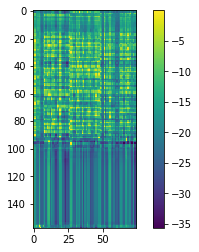

-------------------------------------------------------------------------------------------------------
09-09 14:47:33
Mean Train Loss: 0.014663461816166947
Mean Evaluation Loss: 0.021597602048540766
-------------------------------------------------------------------------------------------------------
09-09 14:48:08
Mean Train Loss: 0.013841298689487838
Mean Evaluation Loss: 0.02132098203631839
-------------------------------------------------------------------------------------------------------
09-09 14:48:43
Mean Train Loss: 0.014099242339388527
Mean Evaluation Loss: 0.021528694684315813
-------------------------------------------------------------------------------------------------------
09-09 14:49:18
Mean Train Loss: 0.013583398634988962
Mean Evaluation Loss: 0.02166664770006769
-------------------------------------------------------------------------------------------------------
09-09 14:49:53
Mean Train Loss: 0.013371745527456317
Mean Evaluation Loss: 0.021723233180360076
--

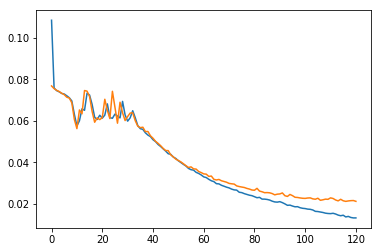

최--------------------그  복신이 대ᄋᄋ  텍 혁간성길라ᅡ고  알려-지-면ᄉ서----  ᅩᅩ식으ᅳ 하늘 여-자ᄃ들이-  늘ᆯ고ᅩ 있어ᄋ요ᅭ-------------------------------------.<eos>
최그 복신이 대ᄋ 텍 혁간성길라고 알려지면서 ᅩ식으 하늘 여자들이 늘고 있어요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


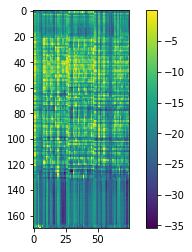

요----------------즘-에ᄂ느ᅳᆫᆫ---  자-기  부ᄆ문임이 나ᅡ 선애ᅢᆼ임을ᆯ---  종갱아ᅡ지 아느ᅳ 아에ᄃ들ᅵᅵ ᄆ많아-ᄋ요ᅭᅭ--------------------------------------.<eos>
요즘에는 자기 부문임이 나 선앵임을 종갱아지 아느 아에들ᅵ 많아요.<eos>
요즘에는 자기 부모님이나 선생님을 존경하지 않는 아이들이 많아요.<eos>------------


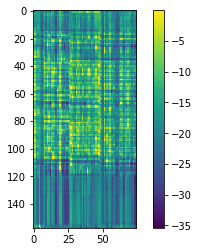

-------------------------------------------------------------------------------------------------------
09-09 14:51:03
Mean Train Loss: 0.01274838807913666
Mean Evaluation Loss: 0.020965792885787662
-------------------------------------------------------------------------------------------------------
09-09 14:51:38
Mean Train Loss: 0.012647145724240656
Mean Evaluation Loss: 0.021522139359861386
-------------------------------------------------------------------------------------------------------
09-09 14:52:13
Mean Train Loss: 0.013429639008164188
Mean Evaluation Loss: 0.022813604867433206
-------------------------------------------------------------------------------------------------------
09-09 14:52:48
Mean Train Loss: 0.013895254830091587
Mean Evaluation Loss: 0.02179319606217773
-------------------------------------------------------------------------------------------------------
09-09 14:53:22
Mean Train Loss: 0.01262743839999024
Mean Evaluation Loss: 0.021443810622578115
---

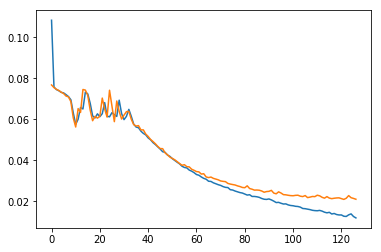

오-----------------ᄂ느  이렇게ᅦ 한-구거ᅥᄋᄋ-ᄀ과만 촌천 반연을 핬스ᅮᆯ 디 되-뎌----  영간 스ᄅ럭교   생각하ᅡᆸ니ᄃ다--------------------------------------------.<eos>
오느 이렇게 한구거ᄋ과만 촌천 반연을 핬스ᅮᆯ 디 되뎌 영간 스럭교 생각합니다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


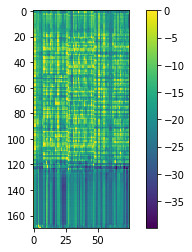

저------------는 앰-식을  적과ᄅ랍ᄋ로ᅩ 줍ᅥᆸ ᄇᆨᄂ는 겁브-다---  포-으ᄅ로  지ᄂ으 게  편해-ᄋ요ᅭ--------------------------------------------------------.<eos>
저는 앰식을 적과랍ᄋ로 줍ᅥᆸ ᄇᆨ는 겁브다 포으로 지ᄂ으 게 편해요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


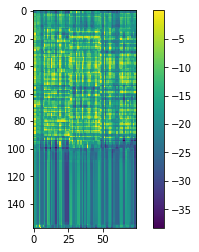

-------------------------------------------------------------------------------------------------------
09-09 14:54:33
Mean Train Loss: 0.01155353208202097
Mean Evaluation Loss: 0.021291699885225834
-------------------------------------------------------------------------------------------------------
09-09 14:55:08
Mean Train Loss: 0.01158451226510803
Mean Evaluation Loss: 0.022207497588588636
-------------------------------------------------------------------------------------------------------
09-09 14:55:43
Mean Train Loss: 0.011990273593197159
Mean Evaluation Loss: 0.02157269387386676
-------------------------------------------------------------------------------------------------------
09-09 14:56:18
Mean Train Loss: 0.01149154258727312
Mean Evaluation Loss: 0.02227183168362977
-------------------------------------------------------------------------------------------------------
09-09 14:56:53
Mean Train Loss: 0.011671289156634039
Mean Evaluation Loss: 0.02144476989220158
------

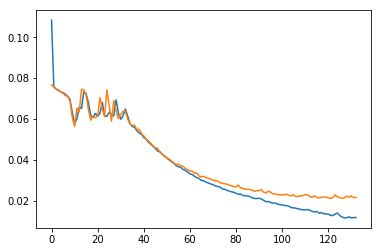

호------------ᆫᆫ마-가 가 거ᄌᄌᆺ-말을 했는-데--------, ᄂ나-징ᄋ  거짓말를ᄒᄒ거  대-무-메--ᅦ 엄마ᄒ한테 더-언 났ᆻ어ᄋ요ᅭ------------------------------------------------------------.<eos>
혼마가 가 거ᄌᆺ말을 했는데, 나징ᄋ 거짓말를ᄒ거 대무메ᅦ 엄마한테 더언 났어요.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


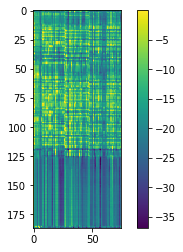

오-----------------------래  장-만는  이-원  종츤희  ᅵᅵ작해-서----  치-을 초ᄋ애 흩 한 거스ᅩᅩᅩᆯ 이-상-됩ᆸ니ᄃ다-----------------------------------.<eos>
오래 장만는 이원 종츤희 ᅵ작해서 치을 초애 흩 한 거스ᅩᆯ 이상됩니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


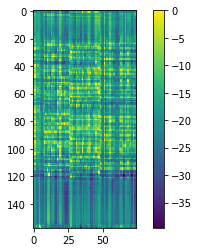

-------------------------------------------------------------------------------------------------------
09-09 14:58:04
Mean Train Loss: 0.011262921304682242
Mean Evaluation Loss: 0.022619721851632954
-------------------------------------------------------------------------------------------------------
09-09 14:58:39
Mean Train Loss: 0.011346615320353373
Mean Evaluation Loss: 0.02126279733685666
-------------------------------------------------------------------------------------------------------
09-09 14:59:13
Mean Train Loss: 0.010574255491582895
Mean Evaluation Loss: 0.021505936964621556
-------------------------------------------------------------------------------------------------------
09-09 14:59:48
Mean Train Loss: 0.010482678541232155
Mean Evaluation Loss: 0.0214209957529128
-------------------------------------------------------------------------------------------------------
09-09 15:00:23
Mean Train Loss: 0.010119822657460384
Mean Evaluation Loss: 0.022076419534958706
---

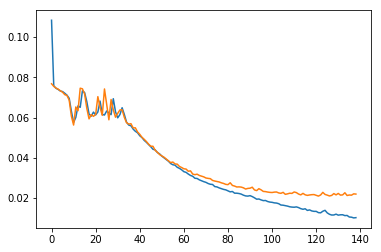

부---------------ᆯ룍 식경이 다ᅡ-축-되-면ᆫ---  글오- 환-경-과ᅪ- 글로-자ᄃ들의  살-이- 질이--  ᄀ개-선될ᆯ 것입니ᄃ다-----------------------------------------.<eos>
불룍 식경이 다축되면 글오 환경과 글로자들의 살이 질이 개선될 것입니다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


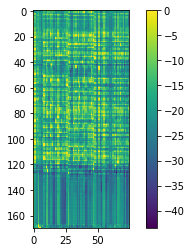

우-------------------ᄅ래  장-만는 이ᅵᅭᄋ우  종층에  시작ᄒ해-서---  칠을 추일 끝ᄒ한 것으로ᅩ 이-상-됩ᆸ니ᄃ다--------------------------------------.<eos>
우래 장만는 이ᅭ우 종층에 시작해서 칠을 추일 끝한 것으로 이상됩니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


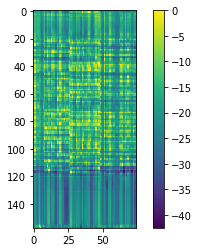

-------------------------------------------------------------------------------------------------------
09-09 15:01:33
Mean Train Loss: 0.01034436669014539
Mean Evaluation Loss: 0.021321611110843092
-------------------------------------------------------------------------------------------------------
09-09 15:02:08
Mean Train Loss: 0.00955940999960257
Mean Evaluation Loss: 0.022006561170612855
-------------------------------------------------------------------------------------------------------
09-09 15:02:42
Mean Train Loss: 0.009666942278144982
Mean Evaluation Loss: 0.022071512560523022
-------------------------------------------------------------------------------------------------------
09-09 15:03:17
Mean Train Loss: 0.010403857525402611
Mean Evaluation Loss: 0.02308290046514215
-------------------------------------------------------------------------------------------------------
09-09 15:03:51
Mean Train Loss: 0.010928030579409876
Mean Evaluation Loss: 0.021965285508989272
---

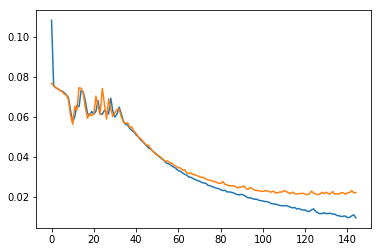

부------------------분은 흘륨한 학자인 ᄀ건 분명ᆼ하-지-만ᆫ-----  저-는 개-인적으로ᅩ  그무-를ᄌ조ᄋ아하ᄌ지 않ᄋ아ᄋ요ᅭ---------------------------------------------------------.<eos>
부분은 흘륨한 학자인 건 분명하지만 저는 개인적으로 그무를조아하지 않아요.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


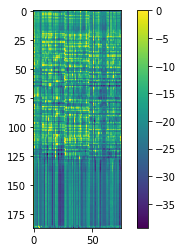

이----------------스-군는 올른드-에ᄉ서  금모-다ᄅᄅᆯᆯ해-득-한 뒤----  국가-적 영움 이 되-었-다----------------------------------------------------.<eos>
이스군는 올른드에서 금모다ᄅᆯ해득한 뒤 국가적 영움 이 되었다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


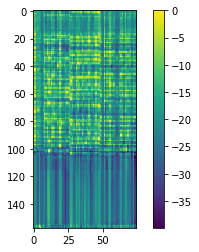

-------------------------------------------------------------------------------------------------------
09-09 15:05:02
Mean Train Loss: 0.00934940949705687
Mean Evaluation Loss: 0.021524118716904697
-------------------------------------------------------------------------------------------------------
09-09 15:05:36
Mean Train Loss: 0.009161113533651809
Mean Evaluation Loss: 0.02187277077646676
-------------------------------------------------------------------------------------------------------
09-09 15:06:11
Mean Train Loss: 0.008785172135875636
Mean Evaluation Loss: 0.021609883310948978
-------------------------------------------------------------------------------------------------------
09-09 15:06:45
Mean Train Loss: 0.009137721775843518
Mean Evaluation Loss: 0.02215542265289224
-------------------------------------------------------------------------------------------------------
09-09 15:07:20
Mean Train Loss: 0.008844653342083685
Mean Evaluation Loss: 0.022131856808646436
---

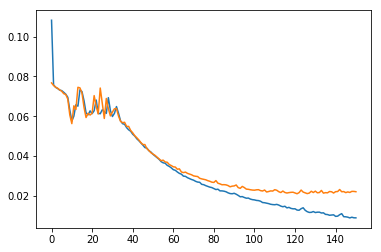

이----------------  수ᄋ읠 십의  자ᄅ리 숫ᄌ자ᄂ는   일이 자ᄅ리 숫자ᄋ의 ᄉ세-래-이-라-----------. -각 숫 장의 하-ᄀ ᅳᆺ-팔이-다------..  ᄋ이ᅵ -수-는---------------------------------?<eos>
이 수읠 십의 자리 숫자는 일이 자리 숫자의 세래이라. 각 숫 장의 하ᄀ ᅳᆺ팔이다. 이 수는?<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


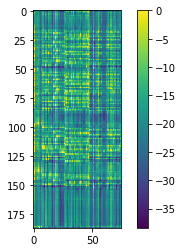

저----------------는ᆫ 그 ᄉ사ᄅ람이----  마ᄋ이얼이  여전들ᅳᆯ 대하는 테-도-ᄀ가--  마ᅡᅳᆷᆷᄋ 안 들어ᄋᄋ요--------------------------------------------------.<eos>
저는 그 사람이 마이얼이 여전들ᅳᆯ 대하는 테도가 마ᅳᆷᄋ 안 들어요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


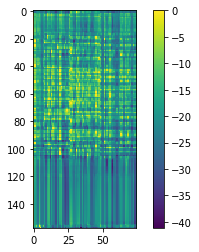

-------------------------------------------------------------------------------------------------------
09-09 15:08:30
Mean Train Loss: 0.008439844934210213
Mean Evaluation Loss: 0.021483969413987947
-------------------------------------------------------------------------------------------------------
09-09 15:09:05
Mean Train Loss: 0.00801577742309627
Mean Evaluation Loss: 0.022074663924054033
-------------------------------------------------------------------------------------------------------
09-09 15:09:40
Mean Train Loss: 0.008107926612045268
Mean Evaluation Loss: 0.021580251148417145
-------------------------------------------------------------------------------------------------------
09-09 15:10:15
Mean Train Loss: 0.0076409125124111575
Mean Evaluation Loss: 0.021945142204076312
-------------------------------------------------------------------------------------------------------
09-09 15:10:49
Mean Train Loss: 0.007610048029337156
Mean Evaluation Loss: 0.022022418290422813


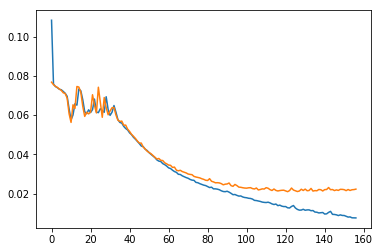

저--------------희  애-장이  목-든 폼ᄆ목이----  이-번 주-에  최-ᄀ고----  삼신 퍼-센-틋-까-지ᅵ- 할인 판매-를 합니ᄃ다-------------------------------------------------------.<eos>
저희 애장이 목든 폼목이 이번 주에 최고 삼신 퍼센틋까지 할인 판매를 합니다.<eos>
저희 매장의 모든 품목이 이번 주에 최고 삼십 퍼센트까지 할인 판매를 합니다.<eos>-----------------


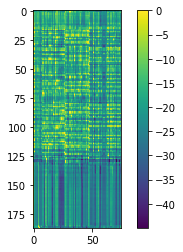

이---------------ᆫ-날에ᄂ는ᆫ---- 하-시-들의 손-발다ᅡᅡ을ᆯ  자랄ᄋᆸ헤 ᄂᆫ으  성ᄉᆼᆼ임들이 있어ᅥᆻ어ᄋᄋ요ᅭ------------------------------------------------.<eos>
인날에는 하시들의 손발다을 자랄ᄋᆸ헤 ᄂᆫ으 성ᄉᆼ임들이 있었어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


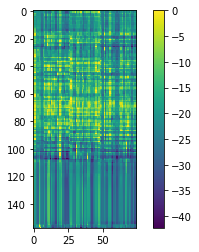

-------------------------------------------------------------------------------------------------------
09-09 15:11:59
Mean Train Loss: 0.008755652562329673
Mean Evaluation Loss: 0.021887076073724237
-------------------------------------------------------------------------------------------------------
09-09 15:12:34
Mean Train Loss: 0.007910269688696325
Mean Evaluation Loss: 0.02283568286479503
-------------------------------------------------------------------------------------------------------
09-09 15:13:10
Mean Train Loss: 0.007801940347622725
Mean Evaluation Loss: 0.022439572493603704
-------------------------------------------------------------------------------------------------------
09-09 15:13:44
Mean Train Loss: 0.008429974162246454
Mean Evaluation Loss: 0.022576458320008232
-------------------------------------------------------------------------------------------------------
09-09 15:14:19
Mean Train Loss: 0.007756406992477945
Mean Evaluation Loss: 0.022466443034030587
-

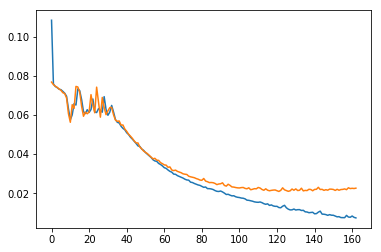

그------------------녀-는 자신ᄋ에 재ᄂ능을 이-용해-----  명예하ᅡ 볼를 추ᄀ구하ᄂ은 데는-  아-묵 ᄀ관심이  없었ᆻᄃ다------------------------------------------------------------.<eos>
그녀는 자신에 재능을 이용해 명예하 볼를 추구하ᄂ은 데는 아묵 관심이 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


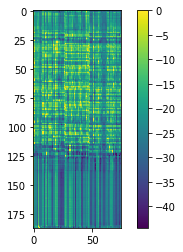

요---------ᆷ-줌ᄋ에ᄂ는ᆫ--  포-주-너ᄋ와ᅪ  사-츠리ᅵᅵᅵ  경-계-가-  분령ᆼ하  자닌 격으라ᅡᅩ  많아ᅡᄋ요ᅭ----------------------------------------------------.<eos>
욤줌에는 포주너와 사츠리 경계가 분령하 자닌 격으라ᅩ 많아요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


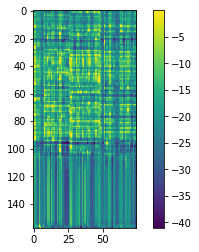

-------------------------------------------------------------------------------------------------------
09-09 15:15:29
Mean Train Loss: 0.006867134259330945
Mean Evaluation Loss: 0.02223588428522696
-------------------------------------------------------------------------------------------------------
09-09 15:16:05
Mean Train Loss: 0.006957677141780475
Mean Evaluation Loss: 0.022377310300399474
-------------------------------------------------------------------------------------------------------
09-09 15:16:40
Mean Train Loss: 0.0070386825236426675
Mean Evaluation Loss: 0.022025537291459646
-------------------------------------------------------------------------------------------------------
09-09 15:17:15
Mean Train Loss: 0.007057765802397651
Mean Evaluation Loss: 0.022903363109860325
-------------------------------------------------------------------------------------------------------
09-09 15:17:49
Mean Train Loss: 0.007085342790578855
Mean Evaluation Loss: 0.022362921025755756


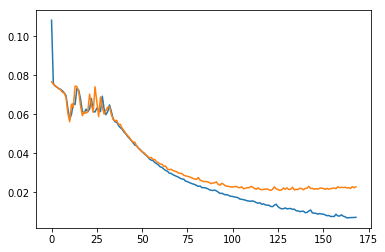

제----------------가 ᄀᄀ  오패ᅵ라의 주ᅵ연을 따냈다는 얘ᄀ기을 들었을 때---------  저-는 정-말ᆯᆯᆯ  믿기ᄌ지기  않았어ᄋᄋ요ᅭ------------------------------------.<eos>
제가 ᄀ 오패ᅵ라의 주ᅵ연을 따냈다는 얘기을 들었을 때 저는 정말 믿기지기 않았어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


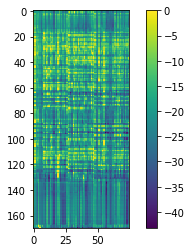

그---------------- 여-성-작-가ᄂ는---  여-성의 사이-저  지이를 놓기ᄂ는 데-  크-기  기-혀ᄒ야-왔ᆻ다----------------------------------------------------.<eos>
그 여성작가는 여성의 사이저 지이를 놓기는 데 크기 기혀ᄒ야왔다.<eos>
그 여성 작가는 여성의 사회적 지위를 높이는 데 크게 기여해 왔다.<eos>-----------------


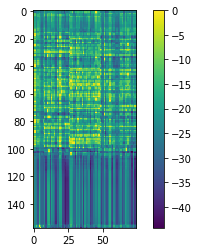

-------------------------------------------------------------------------------------------------------
09-09 15:19:00
Mean Train Loss: 0.007952877971020574
Mean Evaluation Loss: 0.023618065032215325
-------------------------------------------------------------------------------------------------------
09-09 15:19:35
Mean Train Loss: 0.0071002509556678094
Mean Evaluation Loss: 0.023171574045789796
-------------------------------------------------------------------------------------------------------
09-09 15:20:10
Mean Train Loss: 0.008308183530409307
Mean Evaluation Loss: 0.02322302894420884
-------------------------------------------------------------------------------------------------------
09-09 15:20:44
Mean Train Loss: 0.006924592277175618
Mean Evaluation Loss: 0.02269477248932759
-------------------------------------------------------------------------------------------------------
09-09 15:21:19
Mean Train Loss: 0.006486755502780177
Mean Evaluation Loss: 0.022754427586036862
-

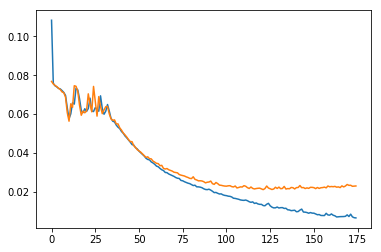

처--------------------ᄋᆷ 이ᄀ곳에 이사 왔을 때---------  ᄀ걸어-서 닪는 거ᄅ리에 싱영푼 바ᄀ게가 있다ᄂ는 게----   참ᆷ ᄌᄌᇂᅩᇂ았ᄋ어ᄋ요ᅭᅭ--------------------------.<eos>
처ᄋᆷ 이곳에 이사 왔을 때 걸어서 닪는 거리에 싱영푼 바게가 있다는 게 참 ᄌᇂᅩᇂ았어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


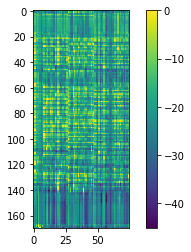

죄-----------------송우--지-ᄆ만ᆫ----  서-새 이-의 ᄀ계획ᄋ은--  실옴 간은상이 없느  걷 같습ᄂ니ᄃ다------------------------------------------------.<eos>
죄송우지만 서새 이의 계획은 실옴 간은상이 없느 걷 같습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


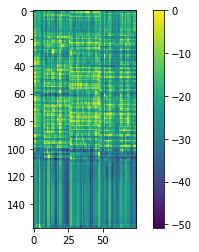

-------------------------------------------------------------------------------------------------------
09-09 15:22:29
Mean Train Loss: 0.006058992137174126
Mean Evaluation Loss: 0.023394943470757445
-------------------------------------------------------------------------------------------------------
09-09 15:23:04
Mean Train Loss: 0.006094036868409953
Mean Evaluation Loss: 0.023177434954126146
-------------------------------------------------------------------------------------------------------
09-09 15:23:39
Mean Train Loss: 0.006032237869690183
Mean Evaluation Loss: 0.023137993092655535
-------------------------------------------------------------------------------------------------------
09-09 15:24:13
Mean Train Loss: 0.006231266729121396
Mean Evaluation Loss: 0.024092659669770693
-------------------------------------------------------------------------------------------------------
09-09 15:24:48
Mean Train Loss: 0.0071361789779950235
Mean Evaluation Loss: 0.023623630529859822

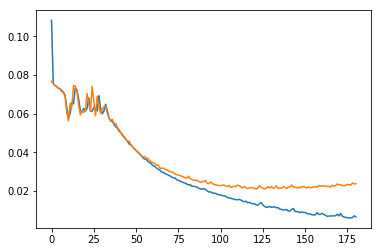

우-------------------------리-는ᆫᆫ---  외-곡인 근로-자-들에ᅴ ᄀ권익을 보호-하-기  위ᄒ해-------  계-석-해ᄉ서  ᄎ최-선을 다ᅡ할 것입니ᅵᄃ다---------------------.<eos>
우리는 외곡인 근로자들에ᅴ 권익을 보호하기 위해 계석해서 최선을 다할 것입니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


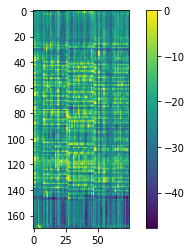

여-------------------ᆼ가  옷당 할명의 외-묵은ᆫ 관광-해-드ᅳᆯ애-  서-울을 방올하ᄀ고 있ᆻ다ᅡ-------------------------------------------------------.<eos>
영가 옷당 할명의 외묵은 관광해들애 서울을 방올하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


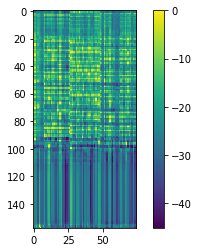

-------------------------------------------------------------------------------------------------------
09-09 15:25:58
Mean Train Loss: 0.005777502028997045
Mean Evaluation Loss: 0.024599599599807488
-------------------------------------------------------------------------------------------------------
09-09 15:26:33
Mean Train Loss: 0.006120334866043995
Mean Evaluation Loss: 0.023355056454638288
-------------------------------------------------------------------------------------------------------
09-09 15:27:07
Mean Train Loss: 0.005913196915579838
Mean Evaluation Loss: 0.023847939177911576
-------------------------------------------------------------------------------------------------------
09-09 15:27:42
Mean Train Loss: 0.005893528931891731
Mean Evaluation Loss: 0.023792303820188924
-------------------------------------------------------------------------------------------------------
09-09 15:28:17
Mean Train Loss: 0.005598703869881037
Mean Evaluation Loss: 0.023698166904629867


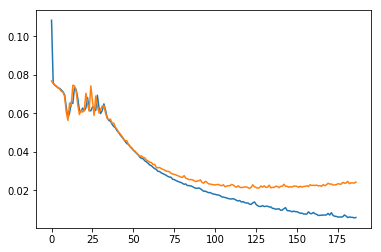

카--------------------드를 분지-하-거ᄂ나  도난 다-할 경우ᅮ-----  즉-시  신ᄀ고-해-서-----  카-드ᄅ를 정지-시ᅵᄏ켜야 합니ᄃ다-------------------------------------------------------.<eos>
카드를 분지하거나 도난 다할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>
카드를 분실하거나 도난 당할 경우 즉시 신고해서 카드를 정지시켜야 합니다.<eos>--------------------


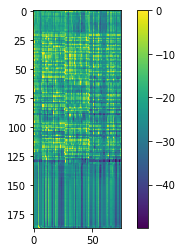

여----------------ᆼ가  오-당 뫌 ᅧᆼ의  애-구-인 관가ᅡᆼ이ᅵ-들이-  서-울을 방온하고ᅩ 있ᆻ다ᅡ----------------------------------------------------------.<eos>
영가 오당 뫌 ᅧᆼ의 애구인 관강이들이 서울을 방온하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


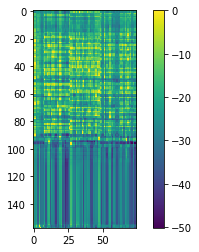

-------------------------------------------------------------------------------------------------------
09-09 15:29:28
Mean Train Loss: 0.005499629682944237
Mean Evaluation Loss: 0.023947465043321896
-------------------------------------------------------------------------------------------------------
09-09 15:30:02
Mean Train Loss: 0.005769548141503644
Mean Evaluation Loss: 0.02527097351053533
-------------------------------------------------------------------------------------------------------
09-09 15:30:37
Mean Train Loss: 0.006528100541162911
Mean Evaluation Loss: 0.024015629169709098
-------------------------------------------------------------------------------------------------------
09-09 15:31:13
Mean Train Loss: 0.00567673236667733
Mean Evaluation Loss: 0.02371926873451195
-------------------------------------------------------------------------------------------------------
09-09 15:31:47
Mean Train Loss: 0.007651698063188476
Mean Evaluation Loss: 0.023798241089751888
---

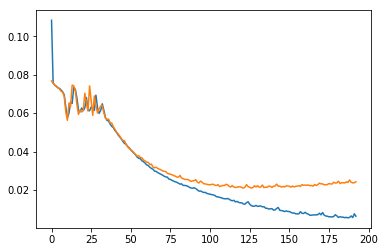

제------------------가 그  오-때라의 ᄌ주연을 따ᄂ냈ᅡᅡᄂᆫ 내-기를 들었을 때--------- 저ᅥᄂ는 정-마----  믿기 지가 않랐ᆻ어ᄋᄋᄋ요----------------------------------.<eos>
제가 그 오때라의 주연을 따냈ᅡᄂᆫ 내기를 들었을 때 저는 정마 믿기 지가 않랐어요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


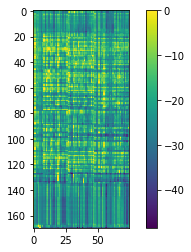

죄--------------송ᄋ하-지-ᄆ만ᆫᆫ---  서-산임의 계-랠-은ᆫ-  실ᄒᆷᆷ 간은ᄉᄉᆼᆼᄋ 없느  것 갇습ᄂ니ᄃ다---------------------------------------------------.<eos>
죄송ᄋ하지만 서산임의 계랠은 실ᄒᆷ 간은ᄉᆼᄋ 없느 것 갇습니다.<eos>
죄송하지만, 선생님의 계획은 실현 가능성이 없는 것 같습니다.<eos>--------------


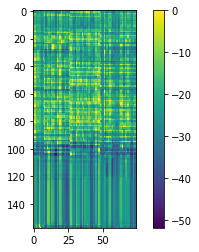

-------------------------------------------------------------------------------------------------------
09-09 15:32:58


KeyboardInterrupt: ignored

In [0]:
EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch()
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_eval.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")